### How to use **`furry-couscous`** classes
C. Heiser, July 2019

In [1]:
from fcc import * # contains dimensionality reduction classes

`couscous` objects can be read straight from a file, or generated from an existing pandas dataframe or numpy array.  
These files can be comma- or tab-delimited, and compressed with `.zip` or `.gz`.  
Here, we will read in a file from [Macosko, _et al._ (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26000488), which has cell and gene labels, and is in a cells-by-genes format.

In [2]:
retina = couscous.from_file(datafile='inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', labels=[0,0], cells_axis=0)

These objects have a bunch of useful attributes:

In [3]:
retina.data['counts'] # gives the full RNA counts data, including cell and gene IDs if available
retina.cell_IDs # list of cell IDs from labels
retina.feature_IDs # list of gene IDs from labels

Index(['10:100015630-100100413:Kitl', '10:100443902-100487350:Tmtc3',
       '10:100488289-100573655:Cep290', '10:100572274-100589259:4930430F08Rik',
       '10:100592386-100618391:1700017N19Rik', '10:101681487-102391469:Mgat4c',
       '10:102512222-102546560:Rassf9', '10:103063198-103236322:Lrriq1',
       '10:10335703-10472326:Adgb', '10:103367808-103419378:Slc6a15',
       ...
       'X:99136130-99148991:Efnb1', 'X:99465734-99471273:Pja1',
       'X:99821021-99848790:Tmem28', 'X:99975606-100400762:Eda',
       'Y:1010543-1028847:Eif2s3y', 'Y:10640942-10643315:Gm20775',
       'Y:1096861-1245759:Uty', 'Y:1260715-1286613:Ddx3y',
       'Y:897788-943811:Kdm5d', 'Y:991630-991748:n-R5s1'],
      dtype='object', length=20478)

We can look at the total number of cells and genes by the shape of the `data['counts']` attribute.  
`data` is a dictionary which will eventually contain key-value pairs for dimension-reduced embeddings such as PCA and t-SNE.

In [4]:
retina.data['counts'].shape

(1326, 20478)

We can feature-select our data with [NVR](https://github.com/KenLauLab/NVR) using the `.nvr_select()` method.  
Here, we will select genes by variance for simplicity:

In [5]:
# this method returns another RNA_counts object with only the top 500 variable genes
retina_var = couscous.var_select(retina, n_features=500)

In [6]:
# check out the shape and selected gene names
print(retina_var.data['counts'].shape)
retina_var.feature_IDs

(1326, 500)


Index(['19:5795690-5802672:Malat1', '6:115931927-115938829:Rho',
       '6:3993797-3997436:Gngt1', '12:109541001-109571726:Meg3',
       '1:87803680-87845158:Sag', 'MT:1094-2675:mt-Rnr2',
       '12:100199435-100209806:Calm1', '2:158375638-158386145:Snhg11',
       '13:99898484-99900683:Cartpt', '14:68083863-68089095:Nefl',
       ...
       '14:52073380-52104028:Hnrnpc', '11:58932288-58938916:Rnf187',
       '18:34344889-34373415:Reep5', '18:30973489-31317290:Rit2',
       '6:131364858-131388450:Ybx3', '10:20148471-20281589:Map7',
       '8:8666577-8690537:Arglu1', '6:17636234-17666972:Capza2',
       '15:41447482-41861048:Oxr1', '8:41239759-41334086:Pcm1'],
      dtype='object', length=500)

We can also downsample the cells in our dataset for quicker analysis.  This instantiates a new instance of the `RNA_counts` class.

In [7]:
retina_var_downsample = couscous.downsample_rand(counts_obj=retina_var, n_cells=1000)
retina_var_downsample.data['counts'].shape

(1000, 500)

Let's analyze the downsampled dataset for simplicity.

In [8]:
# generate PCA object for arcsinh-transformed data with 100 components
%time retina_var_downsample.fcc_PCA(data_type='counts', transform='arcsinh', n_components=100)

CPU times: user 1.14 s, sys: 245 ms, total: 1.38 s
Wall time: 165 ms


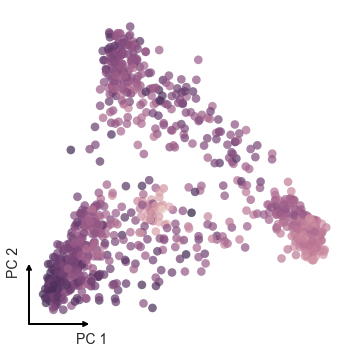

In [9]:
# look at the results
retina_var_downsample.plot('PCA')
# plots are colored by total UMI

Now we can perform our favorite low-dimensional embedding on the arcsinh-transformed data...

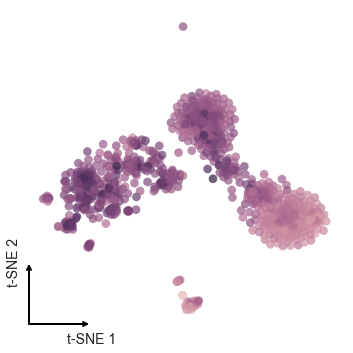

CPU times: user 10.8 s, sys: 49.7 ms, total: 10.8 s
Wall time: 10.6 s


In [10]:
%%time 
retina_var_downsample.fcc_tSNE(data_type='counts', transform='arcsinh', perplexity=30, seed=1)
retina_var_downsample.plot('t-SNE')

Or using **Gene Frequency - Inverse Cell Frequency (GF-ICF)** normalization from [Gambardella and di Bernardo (2019)](https://www.frontiersin.org/articles/10.3389/fgene.2019.00734/full)...

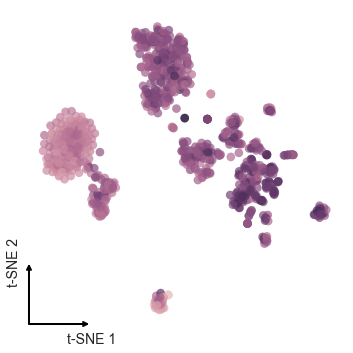

CPU times: user 10.1 s, sys: 48.8 ms, total: 10.2 s
Wall time: 9.99 s


In [11]:
%%time
retina_var_downsample.fcc_tSNE(data_type='counts', transform='gficf', perplexity=30, seed=1)
retina_var_downsample.plot('t-SNE')

Or on the output of the PCA we performed:

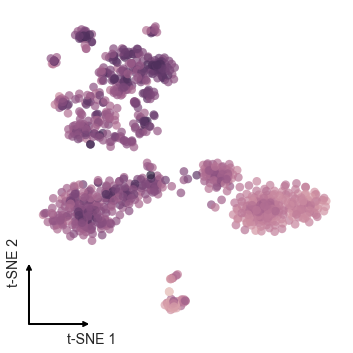

CPU times: user 9.6 s, sys: 48.9 ms, total: 9.64 s
Wall time: 9.43 s


In [12]:
%%time 
retina_var_downsample.fcc_tSNE(data_type='PCA', transform=None, perplexity=30, seed=1)
retina_var_downsample.plot('t-SNE')

Each of these dimensionality reduction (`couscous`) objects we've created has a `.distance_matrix()` method so we can correlate the Euclidean distances across latent spaces pretty easily.

In [12]:
from fcc_utils import *
%time PCA_dist, tSNE_dist, corr_stats, EMD = distance_stats(pre=retina_var_downsample.distance_matrix('PCA'), post=retina_var_downsample.distance_matrix('t-SNE'))

CPU times: user 15 s, sys: 2.69 s, total: 17.7 s
Wall time: 17.8 s


R: 0.7787
n: 1000


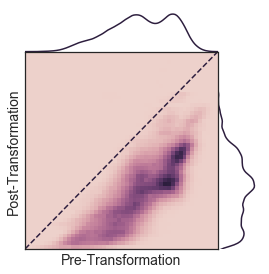

In [13]:
joint_plot_distance_correlation(PCA_dist, tSNE_dist)
print('R: {}\nn: {}'.format(round(corr_stats[0],4), corr_stats[2]))

Looks like a pretty good correlation between t-SNE and PCA spaces (Mantel R = 0.77).  
You can also look at the z-score normalized cumulative distance distributions in each projection and calculate the Wasserstein or Earth Mover's Distance between the two.

EMD: 0.3032


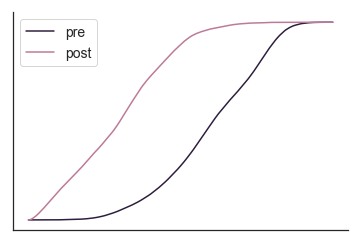

In [14]:
plot_cumulative_distributions(pre_norm=PCA_dist, post_norm=tSNE_dist)
print('EMD: {}'.format(round(EMD,4)))

Density peak clustering is built into the `couscous` objects.  
We can look at the decision graph and assign cluster centers:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117558be0>)

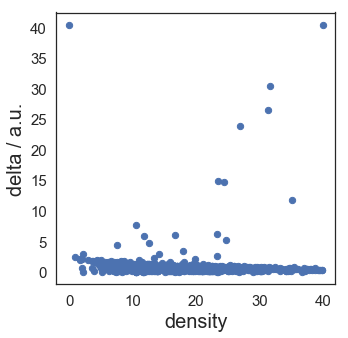

In [15]:
retina_var_downsample.clu['t-SNE'].draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12443d390>)

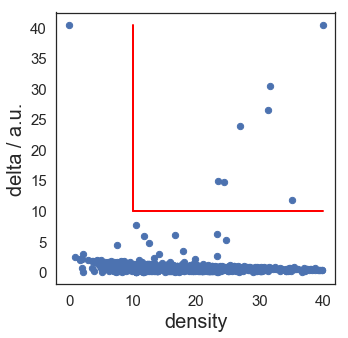

In [16]:
# now, if we assign cutoffs for density and delta, we can generate cluster membership for our tSNE
retina_var_downsample.clu['t-SNE'].assign(10,10)
retina_var_downsample.clu['t-SNE'].draw_decision_graph(min_delta=retina_var_downsample.clu['t-SNE'].min_delta, min_density=retina_var_downsample.clu['t-SNE'].min_density)

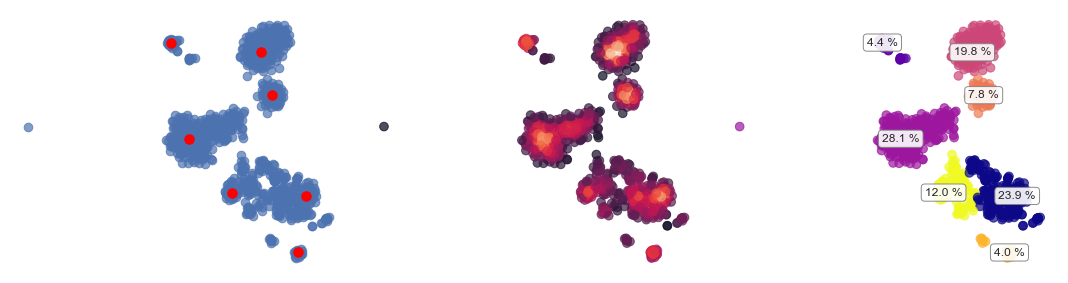

In [17]:
# finally, we can look at the clusters in our tSNE
retina_var_downsample.plot_clusters(data_type='t-SNE')

In [18]:
# silhouette score is automatically calculated as well
print('Silhouette Score: {}'.format(retina_var_downsample.silhouette_score(data_type='t-SNE')))

Silhouette Score: 0.5471541285514832


In [19]:
# we can see a breakdown of the cluster membership as well:
retina_var_downsample.cluster_counts(data_type='t-SNE')

239 cells in cluster 0 (23.9 %)

44 cells in cluster 1 (4.4 %)

281 cells in cluster 2 (28.1 %)

198 cells in cluster 3 (19.8 %)

78 cells in cluster 4 (7.8 %)

40 cells in cluster 5 (4.0 %)

120 cells in cluster 6 (12.0 %)



We can then use the `clu[].membership` attribute to project clusters from one space to another embedding.

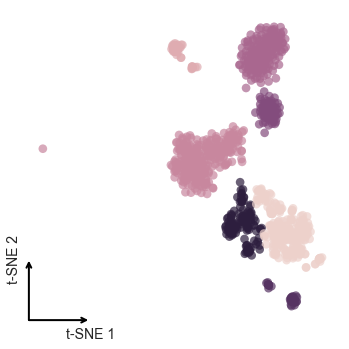

In [20]:
retina_var_downsample.plot(data_type='t-SNE', color=retina_var_downsample.clu['t-SNE'].membership) # PCA-primed t-SNE with 500-gene-primed t-SNE clusters